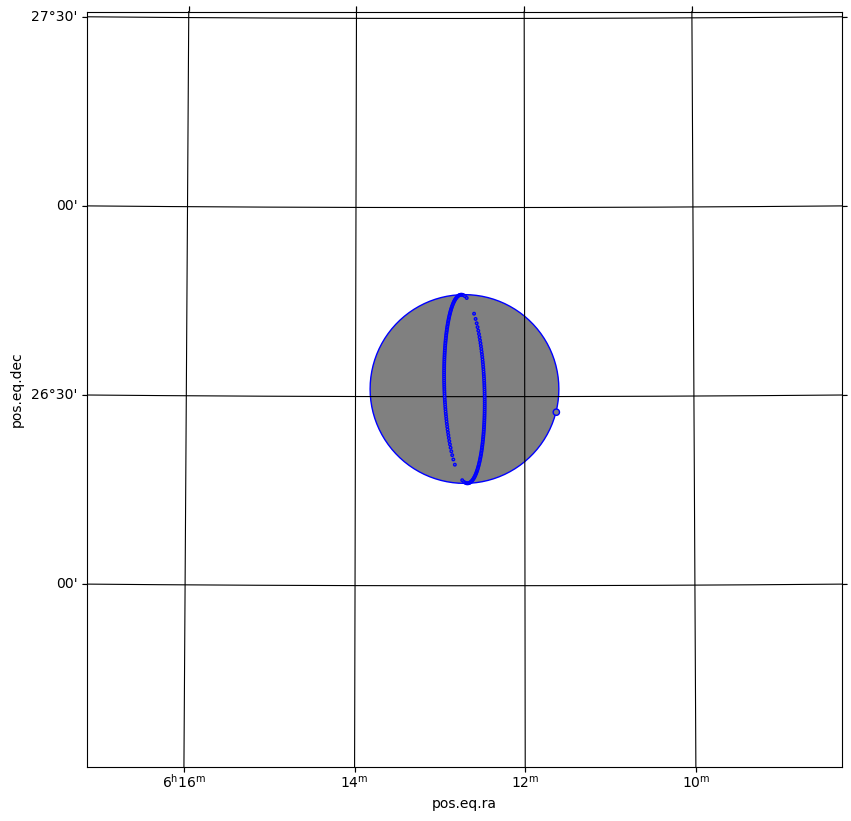

In [15]:
from astropy.visualization.wcsaxes import SphericalCircle
from astropy.coordinates import SkyCoord, EarthLocation, AltAz, ICRS, GCRS, get_moon, get_sun, get_body
from astropy.time import Time
from astropy.wcs import WCS
from astropy.io import fits
import astropy.units as u
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from sympy import symbols
from sympy.solvers import solve
import matplotlib as mpl
from scipy import ndimage
from reproject import reproject_interp

mpl.rc('image', origin='lower')
time = Time('2022-3-11 14:51:21')
# moon info
moon_radi = (1737.10*u.km).to(u.au)
loc_lat = 25.62
loc_lon = 101.13
loc_height = 2223
location = EarthLocation(
    lat=loc_lat*u.deg, lon=loc_lon*u.deg, height=loc_height*u.m)
obsgeoloc, obsgeovel = location.get_gcrs_posvel(time)
sun = get_sun(time)
x, y, z = symbols('x, y, z', real=True) # SymPy

moon = get_moon(time,location)
moon_xyz = np.array([moon.cartesian.x.value, moon.cartesian.y.value, moon.cartesian.z.value]) # float in au, not astropy.Quantity
moon_sphere = (x-moon_xyz[0])**2+(y-moon_xyz[1])**2+(z-moon_xyz[2])**2-(moon_radi.value)**2

sun = get_body('sun',time,location)
sun_xyz = np.array([sun.cartesian.x.value, sun.cartesian.y.value, sun.cartesian.z.value]) # float in au, not astropy.Quantity
sun_vector = sun_xyz-moon_xyz
sun_vector = sun_vector/np.sum(sun_vector**2)
terminator_plane = (x-moon_xyz[0])*sun_vector[0]+(y-moon_xyz[1])*sun_vector[1]+(z-moon_xyz[2])*sun_vector[2]

loc_xyz = np.array([obsgeoloc.x.to(u.au).value, obsgeoloc.y.to(u.au).value, obsgeoloc.z.to(u.au).value])
obs_sight_r_square = np.sum((moon_xyz-loc_xyz)**2) - (moon_radi.value)**2
obs_sight_sphere = (x-loc_xyz[0])**2 + (y-loc_xyz[1])**2 + (z-loc_xyz[2])**2 - obs_sight_r_square
point1, point2 = solve([terminator_plane, moon_sphere], [x, y, z])

line_list = np.array([0,0,0], dtype=complex)
for zes in np.linspace(moon_xyz[2]-moon_radi.value*1, moon_xyz[2]+moon_radi.value*1, 100):
    coord = np.array([complex(eq.subs(z,zes)) for eq in point1])
    if np.logical_or(coord[0].imag!=0,coord[1].imag!=0):
        pass
    else:
        line_list = np.vstack([line_list, coord])
for zes in np.linspace(moon_xyz[2]-moon_radi.value*1, moon_xyz[2]+moon_radi.value*1, 100):
    coord = np.array([complex(eq.subs(z,zes)) for eq in point2])
    if np.logical_or(coord[0].imag!=0,coord[1].imag!=0):
        pass
    else:
        line_list = np.vstack([line_list, coord])
line_list = line_list.real[1:]

location_cartesian = [location.x.value, location.y.value, location.y.value]*u.m
loc_frame_altaz = AltAz(obstime=time, location=location)
loc_gcrs = GCRS(obstime=time, obsgeoloc=obsgeoloc, obsgeovel=obsgeovel)
icrs = ICRS()

zenith = AltAz(az=0*u.deg, alt=90*u.deg, obstime=time, location=location)

moon_eq = get_moon(time,location) # moon sky coordinate in local equatorial frame
moon_ang_radi = np.arcsin(moon_radi/moon_eq.distance.to(u.au)).to(u.arcmin) # moon angular radius

zenith_eq = zenith.transform_to(loc_gcrs)
zenith_ra = zenith_eq.ra.value
zenith_dec = zenith_eq.dec.value

FOV = moon_ang_radi.to(u.deg).value*2*4 # field of view, diameter in degree
p_scale = 1000/FOV # pixels per degree, output im always in 1000pixels
im_scale = np.tan(FOV/720*np.pi)/(FOV/720*np.pi)
im_w = int(FOV*im_scale*p_scale)
im_h = int(FOV*im_scale*p_scale)

wcs = WCS(header={
    'CTYPE1': 'RA---STG',
    'CTYPE2': 'DEC--STG',
    'CRVAL1': moon_eq.ra.value,
    'CRPIX1': im_w/2+0.5,
    'CRVAL2': moon_eq.dec.value,
    'CRPIX2': im_h/2+0.5,
    'CD1_1': -1/p_scale,
    'CD1_2': 0,
    'CD2_1': 0,
    'CD2_2': 1/p_scale,
    'RADESYS': 'GCRS'
})

fig = plt.figure(figsize = (10,10), dpi=100)
ax = fig.add_subplot(111, projection=wcs)
im = np.ones((im_h, im_w))
# im,_ = np.mgrid[0:im_h,0:im_w]
im[:] = np.nan
ax.imshow(im)
ax.coords.grid(True, color='black', ls='solid')
obj = SkyCoord.from_name('hip29390').transform_to(loc_gcrs)
obj1 = SphericalCircle((obj.ra, obj.dec), 0.5*u.arcmin, zorder=50, edgecolor='blue', facecolor='grey', lw=1, ls='-', transform=ax.get_transform('world'))
moon_ax = SphericalCircle((moon_eq.ra, moon_eq.dec), moon_ang_radi,
                        edgecolor='blue', facecolor='grey', lw=1, ls='-',
                        transform=ax.get_transform('world')
                        )
ax.add_patch(obj1)
ax.add_patch(moon_ax)

for line in line_list:
    point1_sky = SkyCoord(x=line[0], y=line[1], z=line[2], frame=loc_gcrs, unit=u.au, representation_type='cartesian').transform_to(loc_gcrs)
    p_ax = SphericalCircle((point1_sky.ra, point1_sky.dec), 0.2*u.arcmin, zorder=50, edgecolor='blue', facecolor='grey', lw=1, ls='-', transform=ax.get_transform('world'))
    ax.add_patch(p_ax)

plt.show()


In [20]:
FOV = moon_ang_radi.to(u.deg).value*2*3.9 # field of view, diameter in degree
moon_size_pixels = 1001
projection_scale = np.tan(FOV/720*np.pi)/(FOV/720*np.pi) # projection distortion compensation
p_scale = moon_size_pixels/projection_scale/FOV # pixels per degree at the reference point (CD_ij(i=j) in fits)
moon_w = moon_size_pixels
moon_h = moon_size_pixels

moon_radius_pixels = moon_size_pixels/2 
terminator_radius_pixels = moon_radius_pixels*1.005 # making the radius of terminator slighly larger than moon angular size to make simulate the true moon phase

cen = int(moon_size_pixels/2) # image center
Y, X = np.mgrid[0:moon_h, 0:moon_w]-cen # make a larger image box
moon_phase = np.arccos((moon.distance**2+moon.separation_3d(sun)**2-sun.distance**2)/(2*moon.distance*moon.separation_3d(sun))).to(u.deg) # 0-180deg
moon_light = np.logical_and(X**2+Y**2<moon_radius_pixels**2,Y>(-np.sqrt(terminator_radius_pixels**2-X**2)*np.cos(moon_phase))) # moon light side mask 
moon_shadow = np.logical_and(X**2+Y**2<moon_radius_pixels**2,Y<(-np.sqrt(terminator_radius_pixels**2-X**2)*np.cos(moon_phase))) # moon shadow side mask 
moon_image = np.zeros((moon_h, moon_w)) # rgba
light_color = 0.75
shadow_color = 0.25
moon_image[moon_light] = light_color #[light_color,light_color,light_color,1]
moon_image[moon_shadow] = shadow_color #[shadow_color,shadow_color,shadow_color,1]
moon_image = ndimage.rotate(moon_image,360-moon.position_angle(sun).degree, reshape=False,order=0)
pad=5
box_w = moon_w+2*pad
box_h = moon_h+2*pad
box = np.zeros((box_h,box_w))
box[pad:pad+moon_h,pad:pad+moon_w] = moon_image

# box = ndimage.zoom(box, 5, order =0)
# box = ndimage.zoom(box, 0.2, order =3)

moon_wcs = WCS(header={
    'CTYPE1': 'RA---STG',
    'CTYPE2': 'DEC--STG',
    'CRVAL1': moon_eq.ra.value,
    'CRPIX1': box_w/2+0.5,
    'CRVAL2': moon_eq.dec.value,
    'CRPIX2': box_h/2+0.5,
    'CD1_1': -1/p_scale,
    'CD1_2': 0,
    'CD2_1': 0,
    'CD2_2': 1/p_scale,
    'RADESYS': 'GCRS'
})


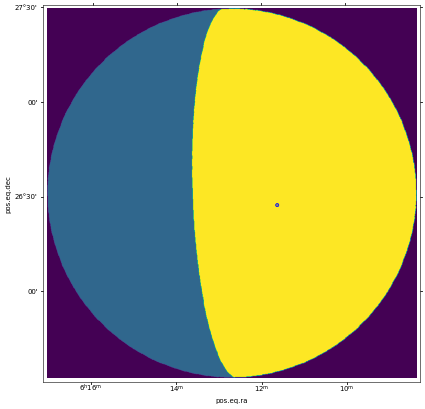

In [21]:
hdu = fits.PrimaryHDU(data = im, header=wcs.to_header())
fig = plt.figure(figsize = (10,10), dpi=50)
ax=fig.add_subplot(111,projection=wcs)
mo, fo = reproject_interp((box, moon_wcs), hdu.header, order = 'nearest-neighbor')
# alpha = np.zeros_like(mo)
# alpha[mo!=0]=1
# alpha[mo==np.nan]=0

# mo = np.dstack((mo,mo,mo,alpha))
ax.imshow(mo)
obj = SkyCoord.from_name('hip29390').transform_to(loc_gcrs)
obj1 = SphericalCircle((obj.ra, obj.dec), 0.5*u.arcmin, zorder=50, edgecolor='blue', facecolor='grey', lw=1, ls='-', transform=ax.get_transform('world'))
ax.add_patch(obj1)
moon_ax = SphericalCircle((moon_eq.ra, moon_eq.dec), moon_ang_radi,
                        edgecolor='blue', facecolor='grey', lw=1, ls='-',
                        transform=ax.get_transform('world')
                        )

# ax.add_patch(moon_ax)
plt.show()

ValueError: Number of world inputs (1) does not match expected (2)

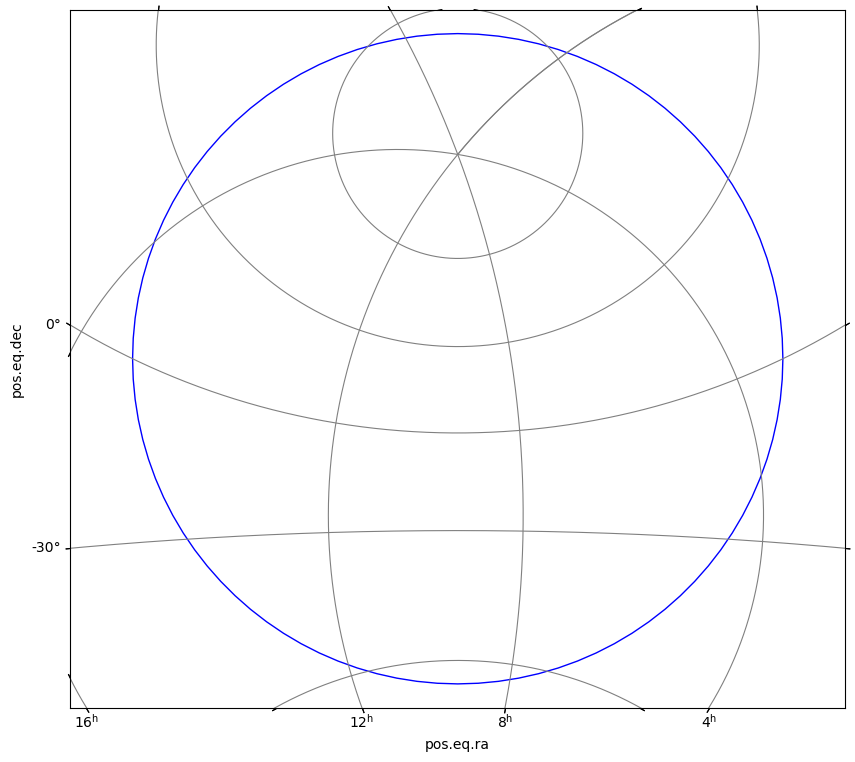

In [3]:
from astropy.visualization.wcsaxes import SphericalCircle
from astropy.coordinates import SkyCoord, EarthLocation, AltAz, ICRS, GCRS, get_moon, get_sun, get_body
from astropy.time import Time
from astropy.wcs import WCS
import astropy.units as u
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from astropy.io import fits
from reproject import reproject_interp
from moon import draw_moon

moon_radi = 1737.10 * u.km

# time
time = Time.now()
# time = Time('2022-3-11 15:00:00')
# oberving location
loc_lat = 25.62
loc_lon = 101.13
loc_height = 2223
location = EarthLocation(lat=loc_lat * u.deg,
                         lon=loc_lon * u.deg,
                         height=loc_height * u.m)
obsgeoloc, obsgeovel = location.get_gcrs_posvel(time)
loc_gcrs = GCRS(obstime=time, obsgeoloc=obsgeoloc, obsgeovel=obsgeovel)

zenith = AltAz(az=0 * u.deg, alt=90 * u.deg, obstime=time, location=location)

moon_eq = get_moon(time).transform_to(
    loc_gcrs)  # moon sky coordinate in local equatorial frame
moon_ang_radi = np.arcsin(moon_radi / moon_eq.distance.to(u.km)).to(
    u.arcmin)  # moon angular radius

zenith_eq = zenith.transform_to(loc_gcrs)
zenith_ra = zenith_eq.ra.value
zenith_dec = zenith_eq.dec.value

FOV = 200  # field of view, diameter in degree
size_pixels = 1000
projection_scale = np.tan(FOV / 720 * np.pi) / (FOV / 720 * np.pi)
p_scale = size_pixels / projection_scale / FOV  # pixels per degree at the reference point (CD_ij(i=j) in fits)
im_w = size_pixels
im_h = size_pixels - 100

im = np.ones((im_h, im_w))
# im,_ = np.mgrid[0:im_h,0:im_w]
im[:] = np.nan

wcs = WCS(
    header={
        'CTYPE1': 'RA---STG',
        'CTYPE2': 'DEC--STG',
        'CRVAL1': zenith_ra,  # zenith_icrs.ra.value,
        'CRPIX1': im_w / 2 + 0.5,
        'CRVAL2': zenith_dec,
        'CRPIX2': im_h / 2 + 0.5,
        'CD1_1': -1 / p_scale,
        'CD1_2': 0,
        'CD2_1': 0,
        'CD2_2': 1 / p_scale,
        'RADESYS': 'GCRS'
    })

im_r = np.full_like(im, 25 / 255)
im_g = np.full_like(im, 32 / 255)
im_b = np.full_like(im, 41 / 255)
im_a = np.full_like(im, 1)
im_rgba = np.dstack((im_r, im_g, im_b, im_a))

im_hdu = fits.PrimaryHDU(data=im, header=wcs.to_header())

fig = plt.figure(figsize=(10, 10), dpi=100)
ax = fig.add_subplot(111, projection=WCS(im_hdu.header, naxis=2))

# ax.imshow(im_rgba)
ax.coords.grid(True, color='grey', ls='solid')

moon = SphericalCircle((moon_eq.ra, moon_eq.dec),
                       moon_ang_radi * 10,
                       edgecolor='blue',
                       facecolor='grey',
                       lw=1,
                       ls='-',
                       transform=ax.get_transform('world'))
horizon = SphericalCircle((zenith_ra * u.deg, zenith_dec * u.deg),
                          90 * u.deg,
                          edgecolor='blue',
                          facecolor='none',
                          lw=1,
                          ls='-',
                          transform=ax.get_transform('world'))
ax.add_patch(horizon)
# ax.add_patch(moon)

sun = get_body('sun', time, location)
moon = draw_moon(time, location, sun, zoom_factor=100)
moon, fo = reproject_interp(moon, im_hdu.header, order = 'nearest-neighbor')
moon[np.isnan(moon)] = 0
moon_insky = np.copy(im_rgba)
moon_insky[moon==0.0,[False, False, False, True]]=0
moon_insky[moon==0.75] = ([0.75]*3).append(1)
moon_insky[moon==0.25] = ([0.25]*3).append(1)
ax.imshow(moon_insky)
wcs.world_to_pixel((moon_eq.ra,moon_eq.dec))
print(moon==0.25)

# if __name__ == '__main__':
#     plt.show()
#     print(np.unique(moon))

In [29]:
a = np.ones((3,3,3))
a[:,:]=[1,2,3]
a

array([[[1., 2., 3.],
        [1., 2., 3.],
        [1., 2., 3.]],

       [[1., 2., 3.],
        [1., 2., 3.],
        [1., 2., 3.]],

       [[1., 2., 3.],
        [1., 2., 3.],
        [1., 2., 3.]]])